In [18]:
import re, orodja
import pandas as pd
import matplotlib.pyplot as plt
file = 'osu_index.txt'
aux_file = 'data-auxf.txt'
page = 'https://osu.ppy.sh/beatmapsets?sort=difficulty_desc&s=ranked'
word_file = 'words.txt'
word_page = 'https://en.wikipedia.org/wiki/Most_common_words_in_English'

## Auxilary code to make a file if one doesn't already exist

In [19]:
def create_files(files=[file, aux_file, 'data.json', 'data.csv']):
    for f in files:
        try:
            a = open(f, 'x')
            a.close()
        except:
            continue

Regex here

In [20]:
curr_re = r'\{"beatmapsets":\[(.*?)\]\}\]'
data_block_re = r'\{.*?\}\]\}'
data_re = re.compile(
    r'\{'
    r'"artist":(?P<artist>.*?)?,.*?,'
    r'"creator":(?P<creator>.*)?,' 
    r'"favourite_count":(?P<fav_count>\d*)?,.*?,'
    r'"id":(?P<id>\d*)?,.*?,'
    r'"play_count":(?P<play_count>\d*)?,.*?,'
    r'"status":(?P<status>.*)?,'
    r'"title":(?P<title>.*?)?,.*?,'
    r'"bpm":(?P<bpm>\d*)?,.*?'
    r'"tags":"(?P<tags>.*?)?",'
    r'"beatmaps":\[(?P<beatmapset>.*?)?\]'
    r'\}',
    flags=re.DOTALL
)

beatmapset_re = re.compile(
    r'\{.*?\}',
    flags=re.DOTALL
)

bmaux_re = re.compile(
    r'[^\\]',
    flags=re.DOTALL
)

beatmap_re = re.compile(
    r'\{.*?,'
    r'"difficulty_rating":(?P<difficulty_rating>.*?),'
    r'"id":(?P<id>\d*?),.*?,'
    r'"total_length":(?P<map_len>\d*?),.*?,'
    r'"accuracy":(?P<accuracy>.*?),'
    r'"ar":(?P<approach_rate>.*?),'
    r'"bpm":(?P<beatmap_bpm>\d*?),.*?,'
    r'"passcount":(?P<passcount>\d*?),'
    r'"playcount":(?P<playcount>\d*?),.*?,'
    r'"max_combo":(?P<max_combo>\d*?)\}',
    flags=re.DOTALL
)

## Separate code snippets here

In [21]:
def scrape(fin: str, out: str) -> None:
    regex = re.compile(curr_re, flags=re.DOTALL) #re.DOTALL postav piko na vse, vkljucno s novo vrstico
    with open(fin) as f:
        stuff = f.read()
        with open(out, 'w', encoding='UTF8')as o:
            print(re.findall(regex, stuff), file=o)

In [22]:
def make_blocks(filename: str) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(data_block_re, flags=re.DOTALL)
    for block in re.findall(regex, stuff):
        l.append(block)
    return l

In [23]:
def scrape_block(block: str) -> dict:
    if not block: return {}
    map = data_re.search(block).groupdict()
    map['fav_count'] = int(map.get('fav_count', 0))
    map['id'] = int(map.get('id', 0))
    map['play_count'] = int(map.get('play_count', 0))
    map['bpm'] = int(map['bpm']) 
    map['tags'] = map['tags'].split(' ')
    # map['beatmapset'] = scrape_beatmaps(map.get('beatmapset', ''))
    beatmapsset_string =  map.get('beatmapset', '')
    l = []
    for match in re.findall(r'\{.*?\}', beatmapsset_string):
        l.append(beatmap_re.search(match).groupdict())
    map['beatmapset'] = l
    return map

In [24]:
def error_check(block: str) -> bool: #eni so prazni iz nekga razloga
    try:
        scrape_block(block)
        return True
    except:
        print('Empty match!')
        return False

Replaces (if \_\_name__ == '\_\_main__')

In [25]:
create_files()
orodja.shrani_spletno_stran(page, file, vsili_prenos=True)
scrape(file, aux_file)
data_blocks = make_blocks(aux_file)
data = []
for i, block in enumerate(data_blocks):
    if not error_check(block):
        print(i)
        continue
    data.append(scrape_block(block))
orodja.zapisi_json(data, 'data.json')
data_format = [
    'id', 
    'title', 
    'creator',
    'artist', 
    'fav_count', 
    'play_count', 
    'bpm', 
    'status', 
    'tags', 
    'beatmapset'
    ]
orodja.zapisi_csv(data, data_format, 'data.csv')

Empty match!
18
Empty match!
20
Empty match!
26
Empty match!
30
Empty match!
39
Empty match!
40


From here is more code for data points and analysis

In [26]:
def filter_tags(l:list[str]) -> list[str]: #tole je nazalost treba ker unfiltered list item je ubistvu samo en doug string
    tags_re = re.compile(
        r'\w+',
        re.DOTALL
    )
    s = re.findall(tags_re, l)
    for i, chars in enumerate(s):
        if chars == '':
            s.pop(i)
    return s

we're gonna need a little bit of extra code to sort through the raw unicode characters

In [27]:
def unicode_checker(s:str) -> bool:
    uni_re = re.compile(r'u[\d\w]{4}', flags=re.DOTALL)
    if re.match(uni_re, s): return True
    return False

In [28]:
def sort_tags(s: pd.Series, reverse=True) -> list[tuple]:
    tags_filtered = s.apply(filter_tags)
    u = {}
    for tags in tags_filtered:
        for tag in tags: #ta dvojn for loop je zelo fajn
            if unicode_checker(tag): continue
            if len(tag) <= 2: continue
            if u == {} or tag not in u.keys():
                u[tag] = 1
            else:
                u[tag] += 1
    return sorted(u.items(), key=lambda x:x[1], reverse=reverse)

Another (if \_\_name__ == '__main\_\_') part

<AxesSubplot: xlabel='Tag'>

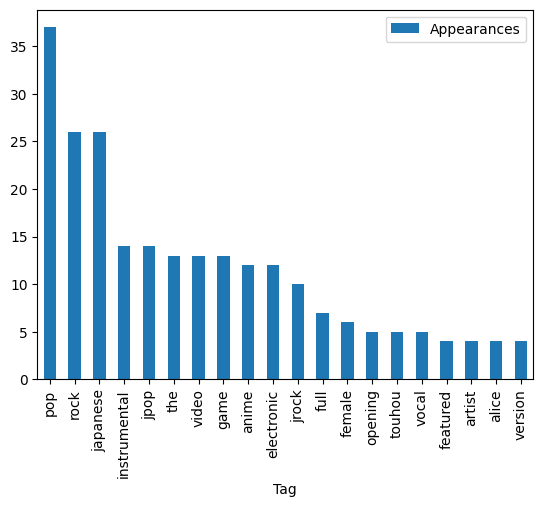

In [29]:
df = pd.read_csv('data.csv')
subtable = df[['id', 'title', 'tags']]
subtable_by_playcount = df[['id', 'title', 'play_count']].sort_values('play_count', ascending=False)
all_tags_sorted = sort_tags(df.tags)
all_tags_sorted_table = pd.DataFrame(all_tags_sorted, columns=['Tag' , 'Appearances'])
all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances')

This next one is of ***FIGURATIVE*** nature, caution is advised

Run this snippet only if you want to _spawn satan himself onto this world_, otherwise it's unnecessary

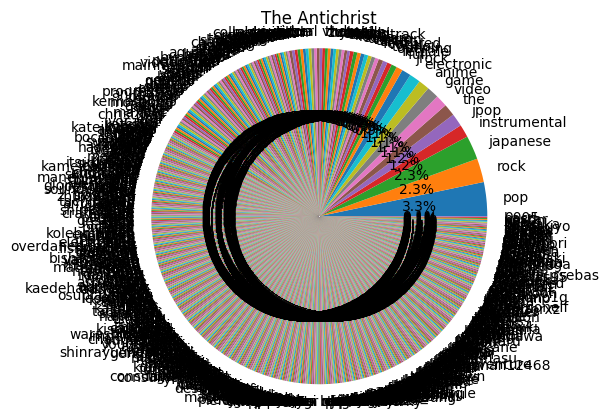

In [59]:
%%script false --no-raise-error
figure1, ax1 = plt.subplots()
ax1.pie(all_tags_sorted_table.Appearances, labels=all_tags_sorted_table.Tag, autopct='%1.1f%%', shadow=False, startangle=0)
ax1.axis('equal')
plt.title('The Antichrist')
#i'm submitting  this one just because of how cursed it is head(20)
plt.show()

Here we begin with the naive Bayes algorithm : scrape the 100 most common english words. Filter the words if they appear in the common ones, such as 'the', 'no', and so on. With the rest try to predict which beatmaps are most played by their tags. I doubt that will work just because of the sheer amount of tags as well as those that duplicate, but maybe we get an interesting result.

In [47]:
orodja.shrani_spletno_stran(word_page, word_file, vsili_prenos=True)
word_re = r'<a href="https://en\.wiktionary\.org/wiki/(.*?)#English" class="extiw" title="wikt:(.*?)">(?P<word>.*?)</a>'
def common_words (filename) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(word_re, flags=re.DOTALL)
    for word in re.findall(regex, stuff):
        l.append(word[0])
    return l 
words = common_words('words.txt')

In [53]:
def filter_common_words(data: list, word_list=words):
    r = []
    for tag in data:
        if tag[0] not in word_list:
            r.append(tag)
    return r
tags_sorted_filtered = pd.DataFrame(filter_common_words(all_tags_sorted),columns=['Tag' , 'Appearances'])

### Random stuff

['pop',
 'rock',
 'japanese',
 'instrumental',
 'jpop',
 'video',
 'game',
 'anime',
 'electronic',
 'jrock',
 'full',
 'female',
 'opening',
 'touhou',
 'vocal',
 'featured',
 'artist',
 'alice',
 'version',
 'dream',
 'sekai',
 'love',
 'iredi',
 'ost',
 'soundtrack',
 'bocchi',
 'ending',
 'mobile',
 'cover',
 'metal',
 'hybrid',
 'zun',
 'theme',
 'vtuber',
 'virtual',
 'youtuber',
 'moon',
 'english',
 'midorijeon',
 'collaboration',
 'shimizu',
 'connect',
 'vol',
 'world',
 'type',
 'original',
 'orchestral',
 'yoshino',
 'kita',
 'gundam',
 'planet',
 'shaper',
 'technical',
 'long',
 'notes',
 'team',
 'shanghai',
 'doujin',
 'trance',
 'character',
 'song',
 'yuuki',
 'angel',
 'shizuku',
 'kazato',
 'asa',
 'shikibe',
 'mayu',
 'ayesha',
 'altugle',
 'swim',
 'aquatope',
 'op1',
 'haruka',
 'bass',
 'tokyo',
 'hyperpop',
 'hyper',
 'tiger',
 'patterned',
 'chiptune',
 'videogame',
 'mairimashita',
 'iruma',
 'kun',
 'season',
 'school',
 'male',
 'kanui',
 'vocals',
 'haru',

In [34]:
l = df.tags[0] #jesus christ okay this thing returns one giant string
s = df.tags.apply(filter_tags)
s[23]
for i in s[23]:
    if i in all_tags_sorted_table.Tag: print(i, 'True')


In [35]:
subtable_by_playcount.head(10)

,id,title,play_count
28,1766740,"""End Time""",32801
32,1922572,"""Kizutsu kedo",19662
38,1806660,"""Mental Chainsaw""",15916
14,1916289,"""Bonetrousle""",15071
27,1846430,"""Ibasho""",8258
40,1883140,"""Blizzard""",8042
20,1779511,"""Is She U.N.Owen?""",7914
39,1843668,"""ARCADIA""",6720
30,1910088,"""Lotus of Haftkarsvar""",5756
35,1864060,"""Ki ga Kurutta Noise""",5515
